<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/introductionVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Méthode de vision par ordinateur "traditionnelles"

## Extraction de contours

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy
import PIL
from PIL import Image
import skimage

def show(x):
    if len(x.shape)==2:
        plt.imshow(x, interpolation='nearest')
        return
    if len(x.shape)==3:
        visu = torch.stack([x[0],x[1],x[2]],dim=-1)
        plt.imshow(visu.numpy(), interpolation='nearest')
    else:
        show(torchvision.utils.make_grid(x))

def readimage(path):
    tmp = PIL.Image.open(path)
    x = torch.Tensor(numpy.asarray(tmp)).clone()
    if len(x.shape)==2:
        return x/255
    else:
        return torch.stack([x[:,:,0],x[:,:,1],x[:,:,2]],dim=0)/255


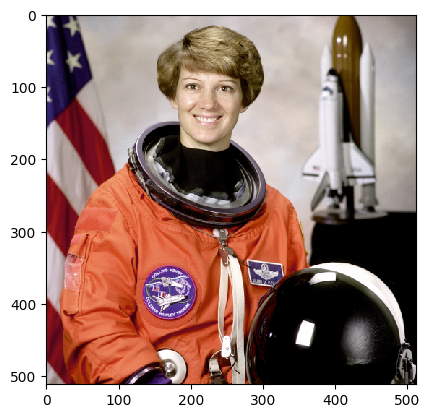

In [2]:
image = skimage.data.astronaut()
image = torch.Tensor(numpy.asarray(image))
image = torch.stack([image[:,:,0],image[:,:,1],image[:,:,2]],dim=0)/255
show(image)

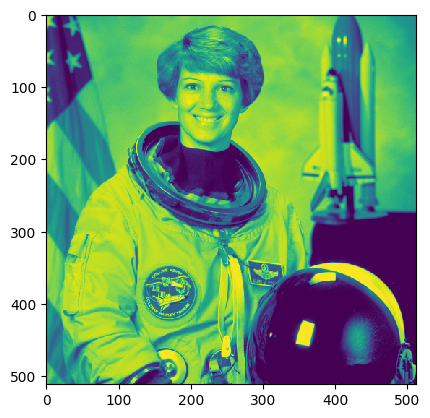

In [3]:
show(image[0])

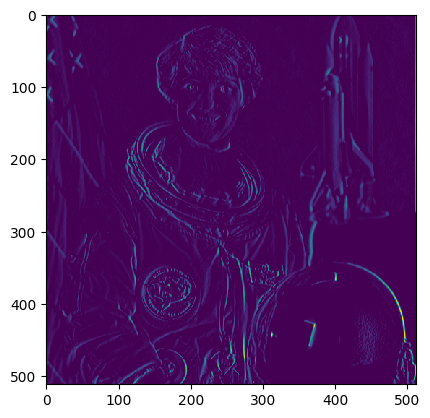

In [4]:
import torch

def sobel_filter1(image):
    sobel_x = torch.tensor([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]]).view(1,1,3,3).float()
    sobel_y = torch.tensor([[1, 2, 1],
                           [0, 0, 0],
                           [-1, -2, -1]]).view(1,1,3,3).float()
    x = image.unsqueeze(0)
    hori = torch.nn.functional.conv2d(x, sobel_x, padding=1)
    vert = torch.nn.functional.conv2d(x, sobel_y, padding=1)

    horiP = hori*(hori>0).float()/hori.max()
    horiN = hori*(hori<0).float()/hori.min()
    vertP = vert*(vert>0).float()/vert.max()
    vertN = vert*(vert<0).float()/vert.min()

    return horiP[0],horiN[0],vertP[0],vertN[0]

# Example usage
gradients = sobel_filter1(image[0])
show(gradients[0])

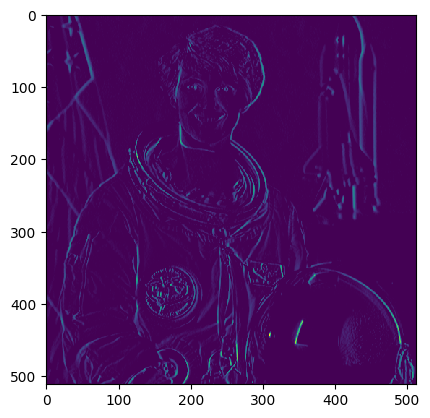

In [5]:
show(gradients[1])

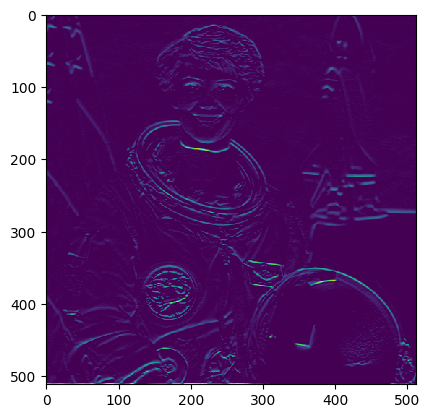

In [6]:
show(gradients[2])

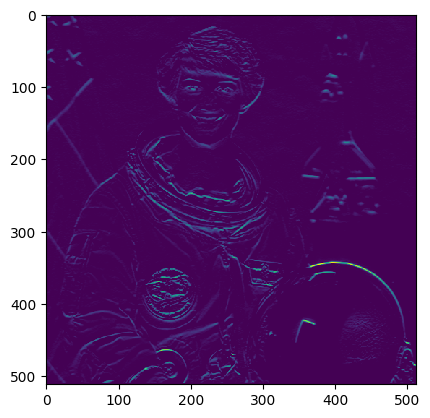

In [7]:
show(gradients[3])

généralement, cette méthode est combinée avec des techniques de double seuillage.

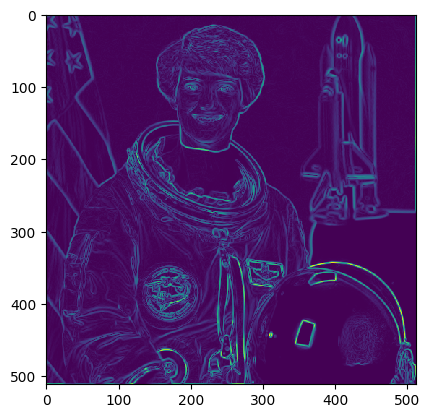

In [8]:
def sobel_filter2(image):
    sobel_x = torch.tensor([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]]).float()/3
    sobel_y = torch.tensor([[1, 2, 1],
                           [0, 0, 0],
                           [-1, -2, -1]]).float()/3
    sobel_x = torch.stack([sobel_x]*3,dim=0).unsqueeze(0)
    sobel_y = torch.stack([sobel_y]*3,dim=0).unsqueeze(0)
    x = image.unsqueeze(0)
    hori = torch.nn.functional.conv2d(x, sobel_x, padding=1).abs()
    vert = torch.nn.functional.conv2d(x, sobel_y, padding=1).abs()

    grad = torch.max(hori,vert)
    return grad[0][0]

gradIm = sobel_filter2(image)
show(gradIm/gradIm.max())

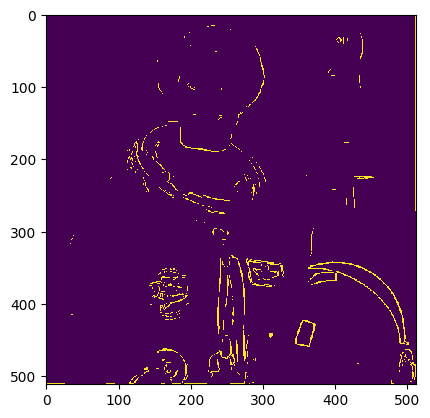

In [9]:
show((gradIm>1.5).float())

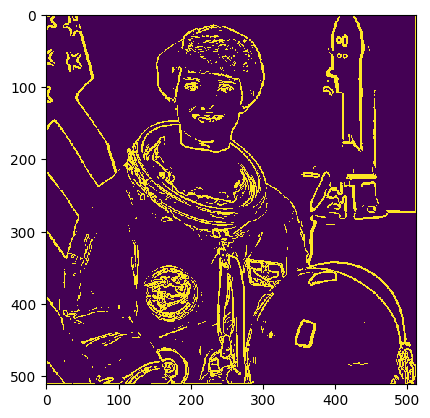

In [10]:
show((gradIm>0.6).float())

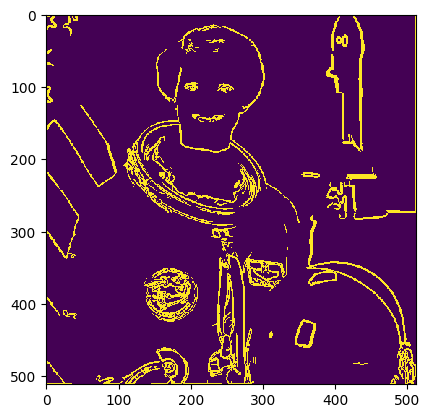

In [11]:
def doubleSeuil(x,seuil_haut=1.5,seuil_bas=0.6):
    xH,xB = (x>seuil_haut).float(),(x>seuil_bas).float()
    xH = xH.view(1,1,x.shape[0],x.shape[1])

    # on garde les pixels de xB quand ils sont connectés à un pixel de xH
    for i in range(100):
        xH = torch.nn.functional.max_pool2d(xH,kernel_size=3,stride=1,padding=1)*xB
    return xH[0][0]

show(doubleSeuil(gradIm))

histogramme of oriented gradient
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html

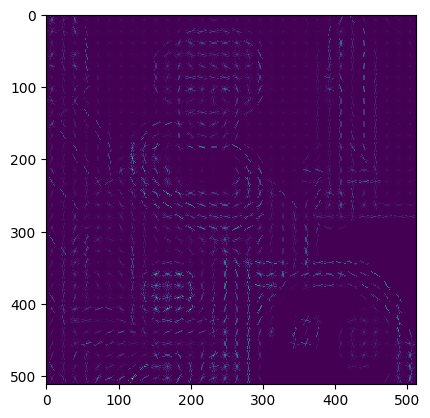

In [12]:
_, hog_image = skimage.feature.hog(skimage.data.astronaut(), orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True, channel_axis=-1)

hog_image = torch.Tensor(numpy.asarray(hog_image)).float().abs()
show(hog_image/hog_image.max())

Maintenant les points d'intérêts !

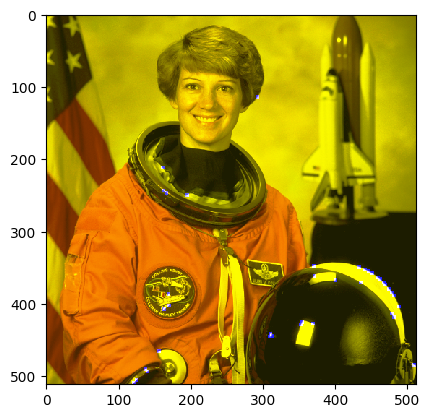

In [44]:
def harris_naif(image):
    sobel_x = torch.tensor([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]]).float()
    sobel_y = torch.tensor([[1, 2, 1],
                           [0, 0, 0],
                           [-1, -2, -1]]).float()
    sobel_x = torch.stack([sobel_x]*3,dim=0).unsqueeze(0)
    sobel_y = torch.stack([sobel_y]*3,dim=0).unsqueeze(0)
    x = image.unsqueeze(0)
    hori = torch.nn.functional.conv2d(x, sobel_x, padding=1)
    vert = torch.nn.functional.conv2d(x, sobel_y, padding=1)

    _,_,h,w = hori.shape
    hori,vert = hori.flatten(), vert.flatten()
    hori,vert = hori/hori.abs().max(), vert/vert.abs().max()
    H = torch.zeros(hori.shape[0],2,2)
    H[:,0,0] = hori*hori
    H[:,1,1] = vert*vert
    H[:,1,0] = hori*vert
    H[:,0,1] = hori*vert

    H = torch.det(H)
    tmp,_ = H.sort()

    H = H.view(h,w).unsqueeze(0)
    H = 100*H-99*torch.nn.functional.max_pool2d(H,kernel_size=5,stride=1,padding=2)
    return (H>=tmp[-50]).float()

visu = image.clone()
point = harris_naif(image)
visu[2] = torch.nn.functional.max_pool2d(point,kernel_size=5,stride=1,padding=2)[0]
show(visu)

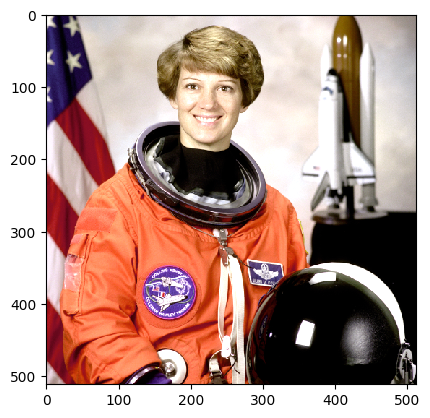

In [52]:
image = skimage.data.astronaut()
p2, p98 = numpy.percentile(image, (10, 90))
image = skimage.exposure.rescale_intensity(image, in_range=(p2, p98))
image = torch.Tensor(numpy.asarray(image))
image = torch.stack([image[:,:,0],image[:,:,1],image[:,:,2]],dim=0)/image.max()
show(image)

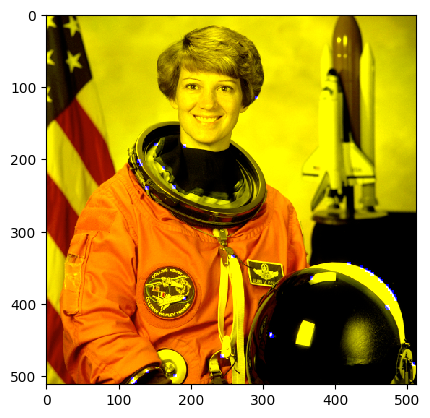

In [53]:
def harris(image):
    sobel_x = torch.tensor([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]]).float()
    sobel_y = torch.tensor([[1, 2, 1],
                           [0, 0, 0],
                           [-1, -2, -1]]).float()
    sobel_x = torch.stack([sobel_x]*3,dim=0).unsqueeze(0)
    sobel_y = torch.stack([sobel_y]*3,dim=0).unsqueeze(0)
    x = image.unsqueeze(0)

    x = torch.nn.functional.gaussian_2d(x,kernel_size=7,padding=3,stride=1)

    hori = torch.nn.functional.conv2d(x, sobel_x, padding=1)
    vert = torch.nn.functional.conv2d(x, sobel_y, padding=1)

    _,_,h,w = hori.shape
    hori,vert = hori.flatten(), vert.flatten()
    hori,vert = hori/hori.abs().max(), vert/vert.abs().max()
    H = torch.zeros(hori.shape[0],2,2)
    H[:,0,0] = hori*hori
    H[:,1,1] = vert*vert
    H[:,1,0] = hori*vert
    H[:,0,1] = hori*vert

    H = torch.det(H) - 0.1*(H[:,0,0]+H[:,1,1])**2
    tmp,_ = H.sort()

    H = H.view(h,w).unsqueeze(0)
    H = 100*H-99*torch.nn.functional.max_pool2d(H,kernel_size=5,stride=1,padding=2)
    return (H>=tmp[-50]).float()


visu = image.clone()
point = harris_naif(image)
visu[2] = torch.nn.functional.max_pool2d(point,kernel_size=5,stride=1,padding=2)[0]
show(visu)